# 3Bの量子化前後比較

## 前提

|||
|--|--|
|使用モデル|Qwen/Qwen2.5-VL-3B-Instruct|
|使用ライブラリ|LMDeploy, transformers(量子化前のみ)|
|GPU|NVIDIA A4000(GPUメモリ16GB)|
|dtype|量子化前: bfloat16<br>量子化後: AWQInt4bit|

※Windows11 + WSL + Docker環境なので、そもそもGPUメモリが0.6GBほど使用されている前提になります。<br>以下にGPUメモリの記載がありますが、それらは全て上記0.6GBが加算された結果になります。

## 結果

||速度|使用GPUメモリ|
|--|--|--|
|量子化前|4.1(s)|10133MiB|
|量子化後|2.45(s)|6152MiB|
|量子化前(transformers)|7.68(s)|9638MiB|


In [1]:
# 必要なライブラリのインポート
from PIL import Image
import matplotlib.pyplot as plt
from lmdeploy import pipeline, TurbomindEngineConfig, ChatTemplateConfig
from lmdeploy.vl import load_image
from lmdeploy.vl.constants import IMAGE_TOKEN

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

import gc
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:51: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


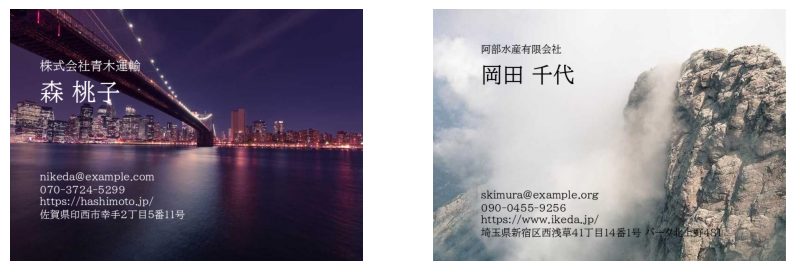

In [2]:
img_path = ["/workspace/1.png", "/workspace/3.png"]

# 画像表示
image = [Image.open(p) for p in img_path]

plt.figure(figsize=(10,10))
for i, img in enumerate(image):
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# 量子化前

In [3]:
# 量子化済みモデルのパス
model_path = "Qwen/Qwen2.5-VL-3B-Instruct"

engine_config = TurbomindEngineConfig(
    dtype="bfloat16",
    cache_max_entry_count=0.01
)

chat_template = ChatTemplateConfig(
    model_name="qwen2_5_vl",
    meta_instruction="あなたはOCRに特化したアシスタントです。"
)

# パイプラインの作成
pipe = pipeline(
    model_path,
    backend_config=engine_config,
    chat_template=chat_template,
    log_level="ERROR"
)

Fetching 14 files: 100%|██████████| 14/14 [00:00<00:00, 115137.76it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
%%time
image = [load_image(p) for p in img_path]

ocr_prompt = f"front image: {IMAGE_TOKEN}\nback image: {IMAGE_TOKEN}\nすべてOCRで読み取ってください。\nフォーマットは以下にしてください。\nFront Image---\n(front imageのOCR結果)\nBack Image---\n(back imageのOCR結果)"

# モデルの実行
output = pipe((ocr_prompt, image), do_sample=False, max_new_tokens=512)

print("----- OCR Result -----")
print(output.text)

----- OCR Result -----
Front Image---
株式会社青木運輸
森 桃子
nikeda@example.com
070-3724-5299
https://hashimoto.jp/
佐賀県印西市幸手2丁目5番11号

Back Image---
阿部水産有限会社
岡田 千代
skimura@example.org
090-0455-9256
https://www.ikeda.jp/
埼玉県新宿区西浅草41丁目14番1号 パーク北土野481
CPU times: user 5.59 s, sys: 1.48 s, total: 7.07 s
Wall time: 4.1 s


In [5]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Sep 14 07:06:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 553.62         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:07:00.0  On |                  Off |
| 42%   62C    P2            117W /  140W |   10133MiB /  16376MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
del pipe
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

# 量子化後

In [3]:
# 量子化済みモデルのパス
model_path = "/workspace/model_3b_4bit"

engine_config = TurbomindEngineConfig(
    cache_max_entry_count=0.01
)

chat_template = ChatTemplateConfig(
    model_name="qwen2_5_vl",
    meta_instruction="あなたはOCRに特化したアシスタントです。"
)

# パイプラインの作成
pipe = pipeline(
    model_path,
    backend_config=engine_config,
    chat_template=chat_template,
    log_level="ERROR"
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
%%time
image = [load_image(p) for p in img_path]

ocr_prompt = f"front image: {IMAGE_TOKEN}\nback image: {IMAGE_TOKEN}\nすべてOCRで読み取ってください。\nフォーマットは以下にしてください。\nFront Image---\n(front imageのOCR結果)\nBack Image---\n(back imageのOCR結果)"

# モデルの実行
output = pipe((ocr_prompt, image), do_sample=False, max_new_tokens=512)

print("----- OCR Result -----")
print(output.text)

----- OCR Result -----
Front Image---
株式会社青木運輸
森 桃子
nikeda@example.com
070-3724-5299
https://hashimoto.jp/
佐賀県印西市幸手2丁目5番11号
---
Back Image---
阿部水産有限会社
岡田 千代
skimura@example.org
090-0455-9256
https://www.ikeda.jp/
埼玉県新宿区西浅草41丁目14番1号 パーク北土野481

CPU times: user 4.12 s, sys: 1.31 s, total: 5.43 s
Wall time: 2.45 s


In [6]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Sep 14 07:00:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 553.62         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:07:00.0  On |                  Off |
| 55%   72C    P2            118W /  140W |    6152MiB /  16376MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
del pipe
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

# 量子化前(transformers)

In [3]:
model_path = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path, 
    torch_dtype="bfloat16", 
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
%%time

messages = [
    {
        "role": "system", 
        "content": "あなたはOCRに特化したアシスタントです。"
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "front image: "},
            {"type": "image", "image": img_path[0]},
            {"type": "text", "text": "back image: "},
            {"type": "image", "image": img_path[1]},
            {"type": "text", "text": "すべてOCRで読み取ってください。\nフォーマットは以下にしてください。\nFront Image---\n(front imageのOCR結果)\nBack Image---\n(back imageのOCR結果)"},
        ],
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# image_inputs, video_inputs = process_vision_info([messages])
inputs = processor(text=[text], images=[Image.open(p) for p in img_path], padding=True, return_tensors="pt")
inputs = inputs.to('cuda')

output_ids = model.generate(**inputs, max_new_tokens=512, do_sample=False)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

print("----- OCR Result -----")
print(output[0])

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


----- OCR Result -----
Front Image---
株式会社青木運輸
森 桃子
nikeda@example.com
070-3724-5299
https://hashimoto.jp/
佐賀県印西市幸手2丁目5番11号

Back Image---
阿部水産有限会社
岡田 千代
skimura@example.org
090-0455-9256
https://www.ikeda.jp/
埼玉県新宿区西浅草41丁目14番1号 パーク北土野481
CPU times: user 6.26 s, sys: 1.39 s, total: 7.65 s
Wall time: 7.68 s


In [5]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Sep 14 07:09:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 553.62         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:07:00.0  On |                  Off |
| 44%   65C    P2            104W /  140W |    9638MiB /  16376MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
del model
del text
del inputs
del processor
gc.collect()
torch.cuda.empty_cache()